# Is this Sean Marks last chance to build a good team in Brooklyn? #
*July 9. 2024*

I'm a Brooklyn Nets fan, and with the [2nd worst loss in Nets Franchise history against the Celtics](https://www.nydailynews.com/2024/02/14/nets-embarrassed-celtics-mikal-bridges-jayson-tatum-jacque-vaughn/) this past season, I wanted to assess whether Nets GM Sean Mark, who is approaching 10 years of being the Nets GM, knows what he is doing and whether or not we're headed in the right direction. 

**Objective:** Explore various metrics that encapsulate whether or not an NBA team's GM is doing a good job or not:
- Win Loss Record
- Playoff Appearances
- Fan Sentiment Analysis
- Salary Cap Management
- Draft Success Rate
- Trade Impact Analysis

### 1. Win-Loss Record since taking the GM role ###

In [38]:
# import the necessary libraries
# It'd be interesting to see how many all-stars have been involved in those wins since that GM has been there
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
pio.renderers.default = "plotly_mimetype+notebook"
import plotly.graph_objs as go
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import leaguegamefinder, playbyplay, playbyplayv2, playercareerstats
from nba_api.stats.library.parameters import Season, SeasonType

import os
os.add_dll_directory(r"C:\Program Files\GTK3-Runtime Win64\bin")
from matplotlib.patches import Arc
import itertools
from PIL import Image
import time
from py_ball import synergy, image

In [39]:

nba_general_managers = {
    'Landry Fields (Atlanta Hawks)': '2022-06-13', #done
    'Brad Stevens (Boston Celtics)': '2021-07-04', #done
    'Sean Marks (Brooklyn Nets)': '2016-02-18', #done
    'Mitch Kupchak (Charlotte Hornets)': '2018-04-08', #done
    'Marc Eversley (Chicago Bulls)': '2020-04-01', #done
    'Mike Gansey (Cleveland Cavaliers)': '2022-02-23', #done
    'Nico Harrison (Dallas Mavericks)': '2021-06-28', #done
    'Calvin Booth (Denver Nuggets)': '2020-07-07', #done
    'Troy Weaver (Detroit Pistons)': '2020-06-18', #done
    'Mike Dunleavy Jr. (Golden State Warriors)': '2023-06-16', #done
    'Rafael Stone (Houston Rockets)': '2020-10-15', #done
    'Kevin Pritchard (Indiana Pacers)': '2017-06-29',#done
    'Trent Redden (Los Angeles Clippers)': '2023-06-01', #done
    'Rob Pelinka (Los Angeles Lakers)': '2017-03-07', #done
    'Zach Kleiman (Memphis Grizzlies)': '2019-04-11', 
    'Andy Elisburg (Miami Heat)': '2013-09-28',
    'Jon Horst (Milwaukee Bucks)': '2017-06-16',
    'Gersson Rosas (Minnesota Timberwolves)': '2019-05-01',
    'David Griffin (New Orleans Pelicans)': '2019-04-17',
    'Leon Rose (New York Knicks)': '2020-03-02',
    'Sam Presti (Oklahoma City Thunder)': '2007-06-07',
    'Jeff Weltman (Orlando Magic)': '2017-05-23',
    'Daryl Morey (Philadelphia 76ers)': '2020-11-02',
    'James Jones (Phoenix Suns)': '2019-04-11',
    'Neil Olshey (Portland Trail Blazers)': '2012-06-04',
    'Monte McNair (Sacramento Kings)': '2020-09-17',
    'Brian Wright (San Antonio Spurs)': '2019-07-24',
    'Bobby Webster (Toronto Raptors)': '2017-06-28',
    'Justin Zanik (Utah Jazz)': '2019-07-22',
    'Tommy Sheppard (Washington Wizards)': '2019-07-22'
}

nba_team_colors = {
    "Atlanta Hawks": "Red",
    "Boston Celtics": "Green",
    "Brooklyn Nets": "Black",
    "Charlotte Hornets": "Teal",
    "Chicago Bulls": "Red",
    "Cleveland Cavaliers": "Wine",
    "Dallas Mavericks": "Blue",
    "Denver Nuggets": "Navy",
    "Detroit Pistons": "Red",
    "Golden State Warriors": "Royal Blue",
    "Houston Rockets": "Red",
    "Indiana Pacers": "Navy",
    "Los Angeles Clippers": "Red",
    "Los Angeles Lakers": "Purple",
    "Memphis Grizzlies": "Navy",
    "Miami Heat": "Red",
    "Milwaukee Bucks": "Green",
    "Minnesota Timberwolves": "Blue",
    "New Orleans Pelicans": "Navy",
    "New York Knicks": "Blue",
    "Oklahoma City Thunder": "Blue",
    "Orlando Magic": "Blue",
    "Philadelphia 76ers": "Blue",
    "Phoenix Suns": "Purple",
    "Portland Trail Blazers": "Red",
    "Sacramento Kings": "Purple",
    "San Antonio Spurs": "Black",
    "Toronto Raptors": "Red",
    "Utah Jazz": "Navy",
    "Washington Wizards": "Red"
}

In [40]:
# Splitting keys into owner name and team name, and creating lists for each
owner_names = []
team_names = []
dates = []
for key, value in nba_general_managers.items():
    owner_name, team_name = key.split(" (")
    team_name = team_name[:-1]  # Removing the closing parenthesis
    owner_names.append(owner_name)
    team_names.append(team_name)
    dates.append(value)

# Creating DataFrame
df = pd.DataFrame({
    'full_name': team_names,
    'general_manager': owner_names,
    'gm_start_date': dates
})

# get_teams returns a list of 30 dictionaries, each an NBA team.
nba_teams = pd.DataFrame(teams.get_teams())

merged_nba_teams = pd.merge(df, nba_teams, on ='full_name', how='right')

wins = []
losses = []
win_perc = []

for index, row in merged_nba_teams.iterrows():
    gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=row['id'])
    historical_games = gamefinder.get_data_frames()[0]
    # historical_games['OPP_TEAM_ABBREVIATION'] = historical_games['MATCHUP'].str.extract(r'[@vs\.] ?(\w+)$')
    # historical_games['LOCATION'] = np.where(historical_games['MATCHUP'].str.contains('@'), 'Home', 'Away')
    gm_wl = historical_games[historical_games['GAME_DATE'] >= row['gm_start_date']]
    win_loss_counts = gm_wl.groupby('WL').size()
    total_wins = win_loss_counts.get('W', 0)
    total_losses = win_loss_counts.get('L', 0)
    winning_percentage = round(total_wins / (total_wins + total_losses) * 100, 2)

    wins.append(total_wins)
    losses.append(total_losses)
    win_perc.append(winning_percentage)

merged_nba_teams['wins_since'] = wins
merged_nba_teams['losses_since'] = losses
merged_nba_teams['winning_percentage'] = win_perc
merged_nba_teams['days_of_ownership'] = (pd.Timestamp.today() - pd.to_datetime(merged_nba_teams['gm_start_date'])).dt.days


# Gather team logos using pyball image and append it to df
list_of_logos = []
for team_id in merged_nba_teams['id']:
    logo = image.Logo(league='NBA', team_id=team_id).image
    logo = logo.convert('RGBA')
    logo.thumbnail((250, 250), Image.LANCZOS)
    list_of_logos.append(logo)
merged_nba_teams['logo'] = list_of_logos

In [41]:
fig = px.bar(merged_nba_teams, x='general_manager', y='winning_percentage', hover_data=['nickname'], color='winning_percentage', text = 'nickname',
             labels={'win%':'Win %'})

# Updating layout
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.update_layout(title={
                'text' : 'Win Percentage of Current NBA GMs',
                'x':0.5,
                 'xanchor': 'center'},
                  xaxis_title='General Managers',
                  yaxis_title='Win %')
fig.update_traces(textfont_size = 14)

fig.add_hline(y=np.mean(merged_nba_teams['winning_percentage']), line_dash="dash", line_color="green", annotation_text="avg win % " + 
              str(round(np.mean(merged_nba_teams['winning_percentage']),2)))

fig.show()

In [42]:
fig2 = px.bar(merged_nba_teams, x='general_manager', y='days_of_ownership',  color='days_of_ownership', text = 'nickname',
             labels={'days of ownership':'Days of Ownership'})

# Updating layout
fig2.update_layout(xaxis={'categoryorder':'total descending'})
fig2.update_layout(title={
                'text' : 'NBA GM Ownership Duration',
                'x':0.5,
                 'xanchor': 'center'},
                  xaxis_title='General Managers',
                  yaxis_title='Days of Ownership')
fig2.update_traces(textfont_size = 14)

fig2.add_hline(y=np.mean(merged_nba_teams['days_of_ownership']), line_dash="dash", line_color="green", annotation_text="avg duration = " + 
              str(round(np.mean(merged_nba_teams['days_of_ownership']),2)))

fig2.show()

We see that the top 5 GMs doing the best so far in terms of Win Percentage belong to the ***Celtics, Bucks, 76ers, Nuggets, and Suns*** respectively. On the other hand we have the ***Spurs, Rockets, Trailblazers, Pistons, and Wizards***... and if you look two spots up, we have the Nets!

It's important to note that this visualization does not show how long each GM has taken the role. So let's visualize this and also visualize their *wins to days of ownership* ratio, where ```x = amount of wins since taking the role``` and ```y = days of ownership```. It would be impressive to see data where a GM garners more wins and less days of ownership.

In [43]:
fig = px.scatter(merged_nba_teams, x='wins_since', y='losses_since', hover_data=['nickname', 'general_manager', 'gm_start_date'])
fig.update_traces(marker_color="rgba(0,0,0,0)")
maxDim = merged_nba_teams[["wins_since", "losses_since"]].max().idxmax()
maxi = merged_nba_teams[maxDim].max()

for i, row in merged_nba_teams.iterrows():
    fig.add_layout_image(
        dict(
            source=list_of_logos[i],
            xref="x",
            yref="y",
            xanchor="center",
            yanchor="middle",
            x=row["wins_since"],
            y=row["losses_since"],
            sizex=150,
            sizey=150,
            sizing="contain",
            layer="above"
        )
    )

fig.update_layout(title={
                'text' : 'Win/Loss Ratio since Current GM took role',
                'x':0.5,
                 'xanchor': 'center'},
                  xaxis_title='Amount of Wins',
                  yaxis_title='Amount of Losses')

fig.update_traces(textfont_size = 14)
fig.update_yaxes(range = [-40,900])
fig.add_hline(y=np.mean(merged_nba_teams['losses_since']), line_dash="dash", line_color="red", annotation_text="avg losses = " + 
              str(round(np.mean(merged_nba_teams['losses_since']),2)))
fig.add_vline(x=np.mean(merged_nba_teams['wins_since']), line_dash="dash", line_color="green", annotation_text="avg wins = " + 
              str(round(np.mean(merged_nba_teams['wins_since']),2)))

# Add trendline
fig.add_trace(go.Scatter(
    x=[0, 900],
    y=[0, 900],
    mode='lines',
    showlegend=False,
    line=dict(color='orange', dash='dash')
))

# Add annotation text
fig.add_annotation(
    x=850,
    y=850,
    text="Linear Trendline",
    showarrow=False,
    font=dict(color="Orange", size=14)
)

fig.show()

Sean Marks has won 348 games and lost 417 games (45.4% Win Rate) since taking the GM role. In comparison with others, Nets rank **23rd** in terms of Win Rate since their current GM took role, in between the Atlanta Hawks and Orlando Magic. So I'd say it's not looking so good. Let's look at his Win-Loss record and compare it with Nets' previous GMs to see how he's doing internally, we can answer who's the *winningest* GM of Nets franchise history. In order to do this, I will:
- Gather all Nets games
- Gather list of all Nets GMs and associated tenure duration
- Compare their Win-Loss Records and see who has the highest win-rate.

### Getting all Nets Games ###

In [44]:
from nba_api.stats.endpoints import leaguegamefinder


nets_master = merged_nba_teams.query('nickname == "Nets"')
nets_id = nets_master['id'].iloc[0]


# Query for all regular season games for Nets
gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=nets_id)

# The first DataFrame of those returned is what we want.
nets = gamefinder.get_data_frames()[0]
nets['OPP_TEAM_ABBREVIATION'] = nets['MATCHUP'].str.extract(r'[@vs\.] ?(\w+)$')
nets['LOCATION'] = np.where(nets['MATCHUP'].str.contains('@'), 'Home', 'Away')

print("Number of historical games:", len(nets))
print("Minimum Game Date:", min(nets['GAME_DATE']))
print("Maximum Game Date:", max(nets['GAME_DATE']))

Number of historical games: 3643
Minimum Game Date: 1983-10-28
Maximum Game Date: 2024-07-21


In [45]:
nets.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION      TEAM_NAME     GAME_ID  \
0     22024  1610612751               BKN  Brooklyn Nets  1522400072   
1     22024  1610612751               BKN  Brooklyn Nets  1522400049   
2     22024  1610612751               BKN  Brooklyn Nets  1522400031   
3     22024  1610612751               BKN  Brooklyn Nets  1522400017   
4     22024  1610612751               BKN  Brooklyn Nets  1522400005   

    GAME_DATE      MATCHUP WL  MIN  PTS  ...  DREB  REB  AST  STL  BLK  TOV  \
0  2024-07-21  BKN vs. CHA  L  201   90  ...    26   31   18   11    5   20   
1  2024-07-18  BKN vs. ORL  W  201  102  ...    29   34   25    6    1    9   
2  2024-07-16  BKN vs. NYK  W  200   92  ...    22   34   19   13    0   14   
3  2024-07-14    BKN @ LAC  L  201   78  ...    16   27   13    6    6   14   
4  2024-07-12    BKN @ IND  W  220   97  ...    27   40   21   17   11   21   

   PF  PLUS_MINUS  OPP_TEAM_ABBREVIATION  LOCATION  
0  19        -8.0                    CHA      Away  
1  14         2.0                    ORL      Away  
2  23        -1.8                    NYK      Away  
3  24       -17.4                    LAC      Home  
4  32         0.4                    IND      Home  

[5 rows x 30 columns]

In [46]:
nets['SEASON_ID'].unique()

array(['22024', '22023', '12023', '42022', '22022', '12022', '42021',
       '52021', '22021', '12021', '42020', '22020', '12020', '42019',
       '22019', '12019', '42018', '22018', '12018', '22017', '12017',
       '22016', '12016', '22015', '12015', '42014', '22014', '12014',
       '42013', '22013', '12013', '42012', '22012', '12012', '22011',
       '12011', '22010', '12010', '22009', '12009', '22008', '12008',
       '22007', '12007', '42006', '22006', '12006', '42005', '22005',
       '12005', '42004', '22004', '12004', '42003', '22003', '12003',
       '42002', '22002', '42001', '22001', '22000', '21999', '21998',
       '41997', '21997', '21996', '21995', '21994', '41993', '21993',
       '41992', '21992', '41991', '21991', '21990', '21989', '21988',
       '21987', '21986', '41985', '21985', '41984', '21984', '41983',
       '21983'], dtype=object)

What do the first digits within each season_id value mean? 
- 1: Preseason games
- 2: Regular season games
- 3: All-Star games
- 4: Playoffs games
- 5: Play-In Tournament games (introduced in recent years)

In [47]:
# Separate into two columns
nets['PLAY_TYPE'] = nets['SEASON_ID'].str[0].astype(int)
nets['SEASON'] = nets['SEASON_ID'].str[1:].astype(int)

I'm going to create a split of the historical data when Sean Marks took ownership. He joined the organization February 2016. Let's say 2016 regular season - onwards is Sean Marks era of BK Nets.

In [48]:
# Split on 2016 regular season
sm_seasons = [i for i in range(2016, 2024)]


nets_post_sm = nets[nets['SEASON'].isin(sm_seasons)]
nets_pre_sm = nets[~nets['SEASON'].isin(sm_seasons)]

In [49]:
# Count the number of 'W' and 'L' within each season
win_loss_counts = nets[nets['PLAY_TYPE'] == 2].groupby(['SEASON', 'WL']).size().unstack(fill_value=0).reset_index()
win_loss_counts['W_L_PERC'] = win_loss_counts['W'] / (win_loss_counts['W'] + win_loss_counts['L'])
win_loss_counts


# Create a line plot using Plotly
fig = px.line(win_loss_counts, x='SEASON', y='W_L_PERC', markers=True,
              labels={'value': 'Percentage', 'SEASON': 'Season'})


# Update layout to position the title in the middle bottom
fig.update_layout(
    title={
        'text': 'Nets W-L% over Regular Seasons since 1990',
        'y': 0.02,  # Adjust this value to position the title vertically (0.02 is near the bottom)
        'x': 0.5,   # Center the title horizontally
        'xanchor': 'center',
        'yanchor': 'bottom'
    }
)


# Update layout for better visualization
fig.update_layout(
    xaxis_title='Season',
    yaxis_title='Percentage',
    hovermode='x unified',
    template='plotly_dark'
)

# Customize hover template to show percentage rounded to two decimals
fig.update_traces(
    hovertemplate='<b>Season</b>: %{x}<br>' +
                  '<b>Percentage</b>: %{y:.2f}<extra></extra>'
)

# Add a vertical line at the year 2016
fig.add_shape(dict(type='line', x0=2016, y0=0, x1=2016, y1=1, xref='x', yref='paper', line=dict(color='red', width=2)))

# Add a horizontal line at percentage .5 to indicate a "good" regular season
# where they win at least half of their games
fig.add_shape(dict(type='line', y0=0.5, y1=0.5, x0=0, x1=1, xref='paper', yref='y', line=dict(color='green', width=1)))

# Add annotation to the red line
fig.add_annotation(dict(x=2016, y=1, xref='x', yref='paper', text='Sean Marks', showarrow=True, arrowhead=2, ax=0, ay=-40, font=dict(color='white')))

# Add a vertical line at the year 2010
fig.add_shape(dict(type='line', x0=2010, y0=0, x1=2010, y1=1, xref='x', yref='paper', line=dict(color='red', width=2)))

# Add annotation to the red line
fig.add_annotation(dict(x=2010, y=1, xref='x', yref='paper', text='Billy King', showarrow=True, arrowhead=2, ax=0, ay=-40, font=dict(color='white')))

# Add a vertical line at the year 2000
fig.add_shape(dict(type='line', x0=2000, y0=0, x1=2000, y1=1, xref='x', yref='paper', line=dict(color='red', width=2)))

# Add annotation to the red line
fig.add_annotation(dict(x=2000, y=1, xref='x', yref='paper', text='Rod Thorn', showarrow=True, arrowhead=2, ax=0, ay=-40, font=dict(color='white')))

# Add a vertical line at the year 2008
fig.add_shape(dict(type='line', x0=2008, y0=0, x1=2008, y1=1, xref='x', yref='paper', line=dict(color='red', width=2)))

# Add annotation to the red line
fig.add_annotation(dict(x=2008, y=1, xref='x', yref='paper', text='Kiki Vandeweghe', showarrow=True, arrowhead=2, ax=-35, ay=-40, font=dict(color='white')))

# Add a vertical line at the year 1990
fig.add_shape(dict(type='line', x0=1990, y0=0, x1=1990, y1=1, xref='x', yref='paper', line=dict(color='red', width=2)))

# Add annotation to the red line
fig.add_annotation(dict(x=1990, y=1, xref='x', yref='paper', text='Willis Reed', showarrow=True, arrowhead=2, ax=-35, ay=-40, font=dict(color='white')))

# Add a vertical line at the year 2008
fig.add_shape(dict(type='line', x0=1996, y0=0, x1=1996, y1=1, xref='x', yref='paper', line=dict(color='red', width=2)))

# Add annotation to the red line
fig.add_annotation(dict(x=1996, y=1, xref='x', yref='paper', text='John Nash', showarrow=True, arrowhead=2, ax=-35, ay=-40, font=dict(color='white')))


fig.show()

# Here's a timeline of the General Managers (GMs) of the Brooklyn Nets:
# According to https://www.retroseasons.com/teams/brooklyn-nets/history/general-managers/
# 1967-1970: Max Zaslofsky
# 1970-1972: Herb Brown
# 1972-1975: Lou Carnesecca
# 1975-1987: Bob MacKinnon
# 1987-1990: Harry Weltman
# 1990-1996: Willis Reed
# 1996-2000: John Nash
# 2000-2008: Rod Thorn
# 2008-2010: Kiki Vandeweghe
# 2010-2016: Billy King
# 2016-present: Sean Marks



How Quickly They Rise... and How Quickly They Fall. 

Sean Marks had a historic run in terms of W-L% in his first couple seasons as GM. Under his tenure, the Nets achieved their highest W-L% ever at 67% win rate during their 2020-21 COVID-Bubble season where the Nets were experimenting with the trio of Kyrie/KD/Harden. This trio will forever remain as the "What could've been" team.

Let's get their average win-rate across their tenure...

In [50]:
# 1990-1996: Willis Reed
# 1996-2000: John Nash
# 2000-2008: Rod Thorn
# 2008-2010: Kiki Vandeweghe
# 2010-2016: Billy King
# 2016-present: Sean Marks

w_reed = range(1990, 1996)
j_nash = range(1996, 2000)
r_thorn = range(2000, 2008)
k_van = range(2008, 2010)
b_king = range(2010, 2016)
s_marks = range(2016, 2025)


print("Willis Reed, GM from 1990-96:", round(win_loss_counts[win_loss_counts['SEASON'].isin(w_reed)]['W_L_PERC'].mean(),2))
print("John Nash, GM from 1996-00:", round(win_loss_counts[win_loss_counts['SEASON'].isin(j_nash)]['W_L_PERC'].mean(),2))
print("Rod Thorn, GM from 2000-08:", round(win_loss_counts[win_loss_counts['SEASON'].isin(r_thorn)]['W_L_PERC'].mean(),2))
print("Kiki Vandeweghe, GM from 2008-10:", round(win_loss_counts[win_loss_counts['SEASON'].isin(k_van)]['W_L_PERC'].mean(),2))
print("Billy King, GM from 2010-16:", round(win_loss_counts[win_loss_counts['SEASON'].isin(b_king)]['W_L_PERC'].mean(),2))
print("Sean Marks, GM from 2016-Present:", round(win_loss_counts[win_loss_counts['SEASON'].isin(s_marks)]['W_L_PERC'].mean(),2))


Willis Reed, GM from 1990-96: 0.43
John Nash, GM from 1996-00: 0.38
Rod Thorn, GM from 2000-08: 0.52
Kiki Vandeweghe, GM from 2008-10: 0.28
Billy King, GM from 2010-16: 0.41
Sean Marks, GM from 2016-Present: 0.48


It seems like we're a franchise that doesn't have a winning culture. Since 1990, our highest win-rate in the regular season has only been 52%, we won at least half our games. That's pretty good, it's hard to win in the NBA. Also, during this time period, we did reach the finals. So that's something to be happy about. But our lowest win rate being 28% is crazy (Thanks Kiki.)

## Additional Metrics: Comparing TS%, AST%, TOV% YoY ##
Add league avg to compare how Nets have performed.

Add team-level features to dataset:
- `TS_PERC` : True Shooting Percentage = takes into account 3 pointers and freethrows into field goal percentage
- `AST_PERC` : Assist Percentage = the percentage of team field goals that were assisted
- `TOV_PERC` : Turnover Percentage = the percentage of possessions that end in a turnover

In [51]:
# True shooting percentage
# TS% = PTS / (2 * (FGA + 0.44 * FTA))
nets['TS_PERC'] = nets['PTS'] / (2 * (nets['FGA'] + .44 * nets['FTA']))

# AST% = AST / FGM
nets['AST_PERC'] = nets['AST'] / nets['FGM']

# TOV% = TOV / (FGA + 0.44 * FTA + TOV)
nets['TOV_PERC'] = nets['TOV'] / (nets['FGA'] + .44 * nets['FTA'] + nets['TOV'])

# Ensure columns are numeric
nets['TS_PERC'] = pd.to_numeric(nets['TS_PERC'], errors='coerce')
nets['AST_PERC'] = pd.to_numeric(nets['AST_PERC'], errors='coerce')
nets['TOV_PERC'] = pd.to_numeric(nets['TOV_PERC'], errors='coerce')

In [52]:
nets_post_sm = nets[nets['SEASON'].isin(sm_seasons)]
nets_pre_sm = nets[~nets['SEASON'].isin(sm_seasons)]

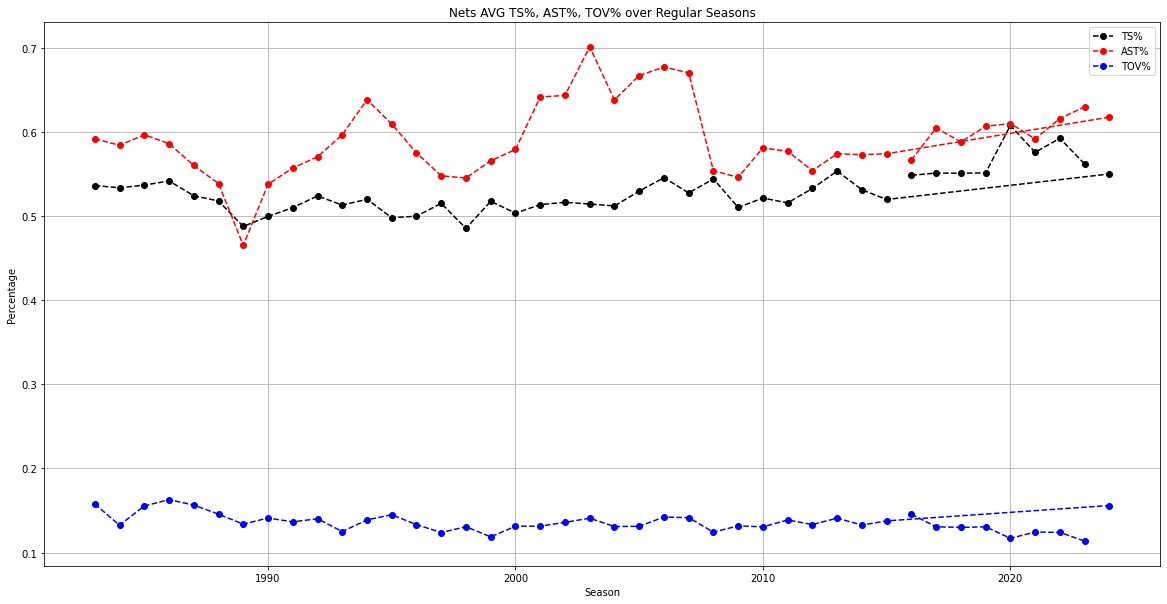

In [53]:
# Plotting
plt.figure(figsize=(20, 10))

# Plot TS% means
plt.plot(nets_post_sm.groupby('SEASON')['TS_PERC'].mean(), marker='o', color = "black", linestyle='--', label='TS%')
plt.plot(nets_pre_sm.groupby('SEASON')['TS_PERC'].mean(), marker='o',  color = "black", linestyle='--')


# Plot AST% means
plt.plot(nets_post_sm.groupby('SEASON')['AST_PERC'].mean(), marker='o', linestyle='--', color = "red", label = 'AST%')
plt.plot(nets_pre_sm.groupby('SEASON')['AST_PERC'].mean(), marker='o', linestyle='--', color = "red")

# Plot TOV% means
plt.plot(nets_post_sm.groupby('SEASON')['TOV_PERC'].mean(), marker='o', linestyle='--', color = "blue", label ='TOV%')
plt.plot(nets_pre_sm.groupby('SEASON')['TOV_PERC'].mean(), marker='o', linestyle='--',  color = "blue")


# Adding labels and title
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.title('Nets AVG TS%, AST%, TOV% over Regular Seasons')
plt.legend()
plt.grid(True)
plt.show()

# 2. Playoff Wins #

Let's gather a list of playoff appearances.

In [54]:
playoff_nets = nets[nets['PLAY_TYPE'] == 4]

# Group by season, WL, and MATCHUP, and count the occurrences
grouped_df = playoff_nets.groupby(['SEASON', 'WL', 'OPP_TEAM_ABBREVIATION']).size().reset_index(name='count')

# Pivot the table to get the desired format
pivot_df = grouped_df.pivot_table(index=['SEASON', 'OPP_TEAM_ABBREVIATION'], columns='WL', values='count', fill_value=0).reset_index()

# Rename the columns for clarity
pivot_df.columns.name = None  # Remove the categories name
pivot_df = pivot_df.rename(columns={'W': 'Wins', 'L': 'Losses'})

# Display the resulting dataframe
pivot_df = pivot_df[['SEASON', 'OPP_TEAM_ABBREVIATION', 'Wins', 'Losses']]

pivot_df

SEASON OPP_TEAM_ABBREVIATION  Wins  Losses
0     1983                   MIL   2.0     4.0
1     1983                   PHL   3.0     2.0
2     1984                   DET   0.0     3.0
3     1985                   MIL   0.0     3.0
4     1991                   CLE   1.0     3.0
5     1992                   CLE   2.0     3.0
6     1993                   NYK   1.0     3.0
7     1997                   CHI   0.0     3.0
8     2001                   BOS   4.0     2.0
9     2001                   CHH   4.0     1.0
10    2001                   IND   3.0     2.0
11    2001                   LAL   0.0     4.0
12    2002                   BOS   4.0     0.0
13    2002                   DET   4.0     0.0
14    2002                   MIL   4.0     2.0
15    2002                   SAS   2.0     4.0
16    2003                   DET   3.0     4.0
17    2003                   NYK   4.0     0.0
18    2004                   MIA   0.0     4.0
19    2005                   IND   4.0     2.0
20    2005                   MIA   1.0     4.0
21    2006                   CLE   2.0     4.0
22    2006                   TOR   4.0     2.0
23    2012                   CHI   3.0     4.0
24    2013                   MIA   1.0     4.0
25    2013                   TOR   4.0     3.0
26    2014                   ATL   2.0     4.0
27    2018                   PHI   1.0     4.0
28    2019                   TOR   0.0     4.0
29    2020                   BOS   4.0     1.0
30    2020                   MIL   3.0     4.0
31    2021                   BOS   0.0     4.0
32    2022                   PHI   0.0     4.0

## To be continued... ##